In [3]:
import numpy as np
import sys
import gym
from gym import error, spaces
from gym import utils
from gym.utils import seeding
import os

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from simulator.utils import Cube2D, Transform2D

In [34]:
class Gaussian(gym.Space):
    """
    A Gaussian space randomizes an action as a datapoint
    using a location and a covariance.
    
    This is actually a multivariate normal distribution (MVN),
    but with non-correlated variables 
    (the covariance matrix is diagonal and positive)
    
    A sample usage:
    self.action_space = Gaussian(location = [-1,2], diagonal_cov = [1,1])
    """
    def __init__(self, location, diagonal_cov, n_objects = 2, shape=None):
        """
        Two kinds of valid inputs
        
        - location and diagonal_cov are scalar -> Gaussian distribution
        - location and diagonal_cov are np array of same size
        """
        self.n_objects = n_objects
        
        if np.isscalar(location) and np.isscalar(diagonal_cov):
            """Gaussian distribution"""
            self.location = np.array([location])
            self.diagonal_cov = np.array([diagonal_cov])
            self.shape = (1,)
        elif isinstance(location, list) and isinstance(diagonal_cov, list):
            assert len(location) == len(diagonal_cov)
            
            self.location = np.array(location)
            self.diagonal_cov = np.diag(diagonal_cov)
            
            self.shape = self.location.shape
        else:
            assert isinstance(location, np.ndarray)
            assert isinstance(diagonal_cov, np.ndarray)
            assert location.shape == diagonal_cov.shape
        
            self.shape = location.shape
            
            self.location = np.flatten(location)
            self.diagonal_cov = np.diag(np.flatten(diagonal_cov))
            
    def sample(self, object_index = None):
        """
        sample an action to take:
        
        if object_index == None:
            sample both object_index and location of final point
        else:
            sample jus the location of final point
        """
        s = np.random.multivariate_normal(self.location, self.diagonal_cov)
        
        # Reshape to original 
        s.shape = self.shape
        
        if object_index:
            return (object_index, s)
        else:
            object_index = np.random.choice(self.n_objects)
            return (object_index, s)
            
    def __repr__(self):
        return "MVN (location= " + str(self.location) + "; variances = " + str(self.diagonal_cov) +")"
    
    def __eq__(self, other):
        return np.allclose(self.location, other.location) and \
                np.allclose(self.diagonal_cov, other.diagonal_cov)

In [55]:
class Uniform(gym.Space):
    """
    A uniform distributioin in a bounded 
    N-dimensional cube
    
    A sample usage:
    Create a square (-1,-1), (-1,1), (1,1), (1,-1)
    self.state_space = Uniform(p = [-1,-1], dimension = [2,2])
    """
    def __init__(self, p, dimension, randomizer = np.random):
        self.p = np.array(p)
        self.dimension = np.array(dimension)
        self.p_opposite = self.p + self.dimension
        self.randomizer = randomizer
        
    def sample(self):
        return self.randomizer.uniform(self.p, self.p_opposite)
    
    def __repr__(self):
        return "Uniform (p= " + str(self.p) + "; dimension = " + str(self.dimension) +")"
    
    def __eq__(self, other):
        return np.allclose(self.p, other.p) and \
                np.allclose(self.dimension, other.dimension)

In [46]:
def make_lines(shape):
    lines = []
    for i in range(len(shape)):
        j = (i + 1) % len(shape)
        lines.append( [ shape[i], shape[j] ] )
    
    return lines

In [69]:
from matplotlib import pyplot as plt
import pylab as pl
from matplotlib import collections as mc

In [71]:
colors = [ (1, 0, 0, 1), (0,1,0,1), (0,0,1,1) ]

In [101]:
class BlockMovementEnv(gym.Env):
    reward_range = (0, 1)
    metadata = {'render.modes': ['human']}
    """
    """
    def __init__(self, target, playground_x = [-1,-1, 0],
                 playground_dim = [2, 2, np.pi/2], name=None, n_objects = 2,
                block_size = 0.15):
        """
        Parameters:
        - name: the name of the event action to be learned
        - target: is a function that produces
        a value between 0 and 1 (event progress function)
        - playground: a rectangle (x, y, rot, width, height, rot_range)
        where (x,y) is a corner of the rectangle
        
        - n_objects: number of objects to be randomized
        
        **Note**
        target_function:
        event progress function will be defined based on the event type 
        currently learned
        
        target_function would be an LSTM
        
        
        """
        self.n_objects = n_objects
        self.playground_x = playground_x
        self.playground_dim = playground_dim
        self.name = name
        self.block_size = block_size
        
        # Action space is dynamically created
        # The action space would be a combination of a 
        self.action_space = None
        # observation space is a subset of multiple object spaces
        self.observation_space = None 
        
        self._seed()
        
        self.object_space = Uniform(p = playground_x, 
                                         dimension = playground_dim, 
                                         randomizer = self.np_random)
        
        
        self._reset()
        
    def _step(self, action):
        # action is generated from the action_policy (external to the environment)
        object_index, position = action
        
        self.s[object_index] = self.s[object_index] + position
        
    
    def _reset(self):
        self.s = []
        # states would be a list of location/orientation for block
        # sampled from the observation space
        for i in range(self.n_objects):
            state = self.object_space.sample()
            self.s.append(state)
        
        self.lastaction=None
        return self.s

    def _render(self, mode='human', close=False):
        if close:
            return
        
        fig, ax = plt.subplots()
        ax.set_xticks(np.arange(self.playground_x[0], 
                                self.playground_x[0] + self.playground_dim[0], 0.1))
        ax.set_yticks(np.arange(self.playground_x[1], 
                                self.playground_x[1] + self.playground_dim[1], 0.1))
        ax.set_xlim([self.playground_x[0], 
                     self.playground_x[0] + self.playground_dim[0]])
        ax.set_ylim([self.playground_x[1], 
                     self.playground_x[1] + self.playground_dim[1]])
        fig.set_size_inches(20, 12)
        
        for i in range(self.n_objects):
            # Obj is action position and rotation of object
            obj = self.s[i]
            position = obj[:2]
            rotation = obj[2]
            scale = self.block_size / 2
            
            c = Cube2D(transform = Transform2D(position, rotation, scale))
            
            shape = c.get_markers()
            
            lines = make_lines(shape)
            lc = mc.LineCollection(lines, colors=colors[i], linewidths=2)
            ax.add_collection(lc)
        
        ax.autoscale()
        ax.margins(0.1)

        plt.show()

    def _seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

In [102]:
env = BlockMovementEnv(None)

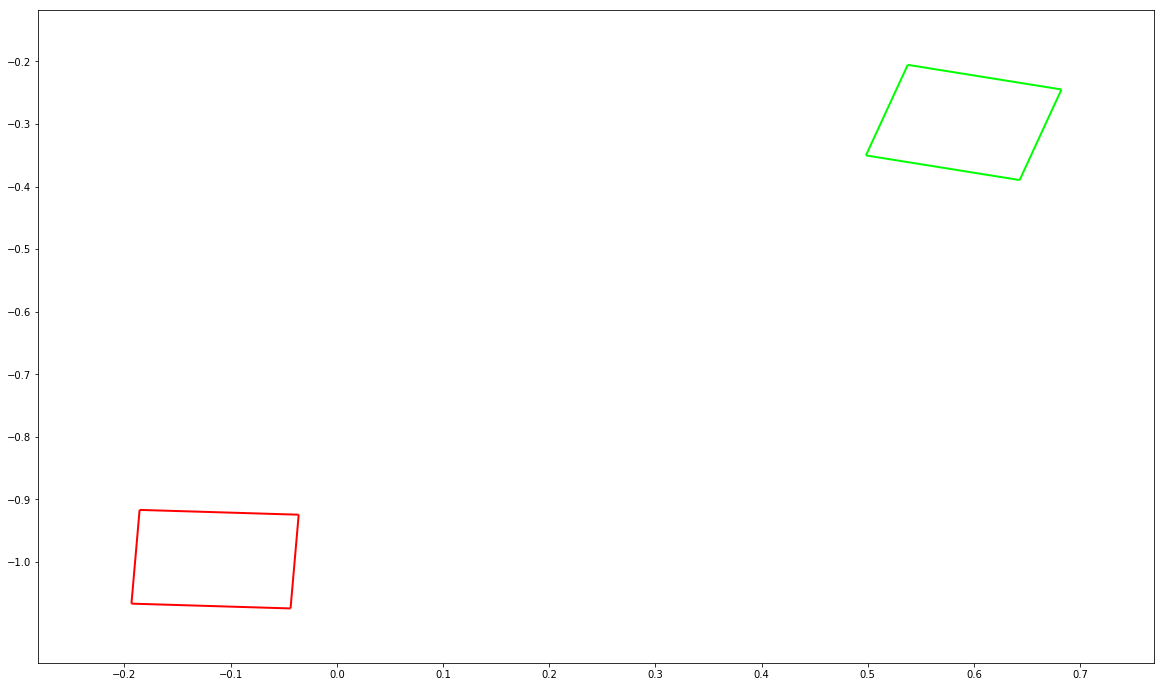

In [103]:
env.render()